In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ODEs
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

# Networks
import networkx as nx
import EoN
from collections import defaultdict 

%matplotlib notebook

In [2]:
# total_tweets is I (Infected)

# Read first 400 timestamps
df = pd.read_csv('../data/timeseries/Verified/TRUMP_CHANTING_VERIFIED.csv')
# df = pd.read_csv('../data/timeseries/Verified/Judicial_Watch_alleges_stolen_election_raw.csv')
# df = pd.read_csv('../data/timeseries/Verified/ballot_harvesting__Ilhan_Omar_Project_Veritas_Video__raw.csv')
# df = pd.read_csv('../data/timeseries/Verified/Machines__Westmoreland_machines_down_raw.csv')
df = df[:400]

yData = np.cumsum(df['total_tweets'])
xData = np.arange(0, len(df), 1)

# Time span for the solve_ivp function
tSpan = [0, len(df)]

# Initial infections at the start
I0 = yData[0]

------------ Estimated Parameters -------------
N = 470116
S0 = 38927.3258653259
S0 = 38927.3258653259
E0 = 20491.01744741838
Z0 = 410140.32450239896
beta = 0.13234520300809
b = 0.005946623315635592
ro = 4.162317921111419
p = 0.049258035991984174
e = 0.035820712491870105
l = 0.11749603626151257


<IPython.core.display.Javascript object>


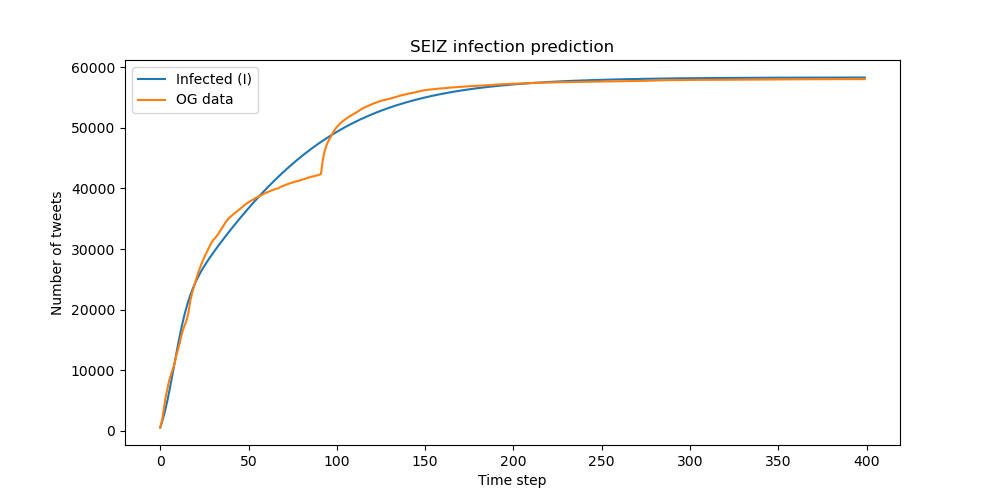

<IPython.core.display.Javascript object>


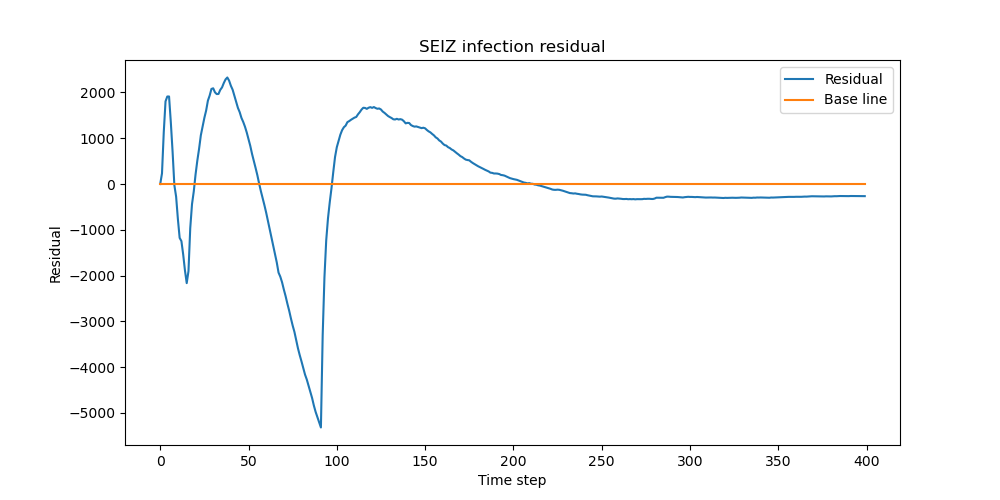

<IPython.core.display.Javascript object>


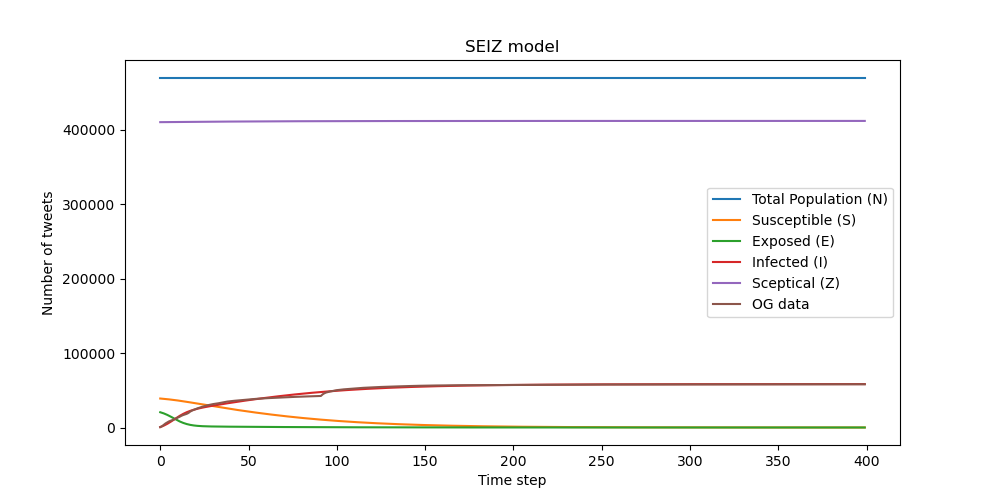

In [50]:
# Run this for the SEIZ model

# Function for SEIZ system of ODEs
# S0, E0, Z0, beta, b, ro, p, e and l are unknown
def seiz(t, y, S0, E0, Z0, beta, b, ro, p, e, l):
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    
    N = S0 + E0 + I0 + Z0
    
    dS = -1 * beta * S * (I / N) - b * S * (Z / N)
    dE = (1 - p) * beta * S * (I / N) + (1 - l) * b * S * (Z / N) - ro * E * (I / N) - e * E
    dI = p * beta * S * (I / N) + ro * E * (I / N) + e * E
    dZ = l * b * S * (Z / N)

    return [dS, dE, dI, dZ]

def solve_seiz(x, *args):
    initialValues = [args[0], args[1], I0, args[2]] # [S0, E0, I0, Z0]
    
    return solve_ivp(seiz, tSpan, initialValues, method='BDF', t_eval=x, args=args).y

def fit_seiz(x, *args):
    # Return the solution for the infections which we can then compare to the OG data
    return solve_seiz(x, *args)[2]

initial_guess = [100, 100, 100, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]
bounds = (0, [9e8, 9e8, 9e8, 100, 100, 100, 1, 1, 1]) # All changing parameters should theoretically be between [0, 1]

popt, pcov = curve_fit(fit_seiz, xData, yData, initial_guess, bounds=bounds)

# Total population
N = round(popt[0] + popt[1] + I0 + popt[2])

print('------------ Estimated Parameters -------------')
print(f'N = {N}')
print(f'S0 = {popt[0]}')
print(f'S0 = {popt[0]}')
print(f'E0 = {popt[1]}')
print(f'Z0 = {popt[2]}')
print(f'beta = {popt[3]}')
print(f'b = {popt[4]}')
print(f'ro = {popt[5]}')
print(f'p = {popt[6]}')
print(f'e = {popt[7]}')
print(f'l = {popt[8]}')

# Fitted SEIZ model with the guessed args
fitted = solve_seiz(xData, *popt)

infected_residuals = yData - fitted[2]

# Plotting

# Prediction accuracy
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection prediction')

plt.plot(fitted[2], label='Infected (I)')
plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_infection.png')

plt.show()

# Infection residual
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection residual')

plt.plot(infected_residuals, label='Residual')
plt.plot([0] * len(df), label='Base line')

plt.xlabel('Time step')
plt.ylabel('Residual')

plt.legend()

plt.savefig('../images/seiz_residual.png')

plt.show()

# Whole SEIZ model
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(fitted[0], label='Susceptible (S)')
plt.plot(fitted[1], label='Exposed (E)')
plt.plot(fitted[2], label='Infected (I)')
plt.plot(fitted[3], label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_full.png')

plt.show()

S0 = round(popt[0])
E0 = round(popt[1])
I0 = round(I0)
Z0 = round(popt[2])

beta = popt[3]
b = popt[4]
ro = popt[5]
p = popt[6]
e = popt[7]
l = popt[8]

## Network

In [4]:
# Power law follower distribution
degrees = []

in_degrees = []
out_degrees = []

for i in range(N):
    n = np.random.uniform(1, 330*1e6) # Random number (rank of a twitter user)
    
    follower_count = 1e7*((1 / n)**0.62)
    
    # We have to scale the "follower_count" based proportionally to the population size N
#     power_law_scaler = follower_count / 1e7
    
#     scaled_follower_count = (N - 1) * power_law_scaler
    
    degrees.append(round(follower_count))

# We sample the in/out degress from the same array
# This is because for the network the sums of in and out degress have to match
in_degrees = random.sample(degrees, len(degrees))
out_degrees = random.sample(degrees, len(degrees))

print(np.array(degrees).max())

34936


In [21]:
# Scale contact rate parameters for the network

average_degree = (np.array(out_degrees).sum() / N)

# Calculates how much bigger the parameters in the ODEs are
# compared to a network with a specific average out-degree
scaler = (N - 1) / average_degree

# The parameters in the ODEs are proportionally larger because of (1 / N)
# Therefore, we divide by N to scale it back for the networks
beta_ntw = (beta * scaler) / N
b_ntw = (b * scaler) / N
ro_ntw = (ro * scaler) / N

print('------------ Scaled Contact Rate Parameters -------------')
print(f'beta = {beta_ntw}')
print(f'b = {b_ntw}')
print(f'ro = {ro_ntw}')

------------ Scaled Contact Rate Parameters -------------
beta = 0.4189614799036209
b = 2.9448610264938186
ro = 817.9763016605733


In [23]:
# Creating a directed network and removing self-loops 

G = nx.directed_configuration_model(in_degrees, out_degrees)
G.remove_edges_from(nx.selfloop_edges(G))

<IPython.core.display.Javascript object>


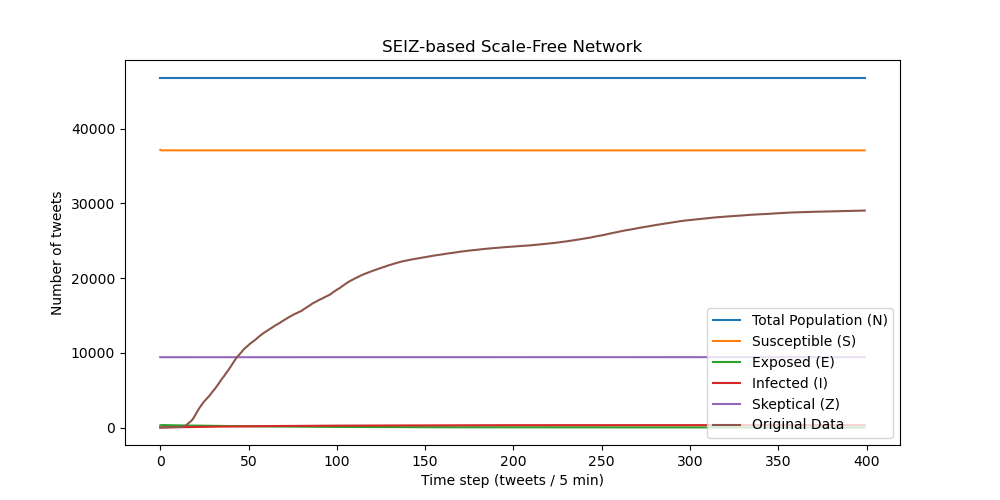

In [24]:
# EoN implementation

# Custom function which sums all rates based on the neighbour amount
# list_nbr is a list of different neighbours to look for (i.e. ['I', 'Z'])
# list_rates is a list of different rates of each list_nbr item
def return_combined_rates(G, node, status, list_nbr, list_rates):
    combined_rate = 0
    
    for i in range(len(list_nbr)):
        nbr_status = list_nbr[i]
        rate = list_rates[i]  
        
        neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == nbr_status])
        
        combined_rate += (rate * neighbours)
    
    return combined_rate

# This function needs to return the rate at which node changes status.
def rate_function(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters
    
    if status[node] == 'E':
        return e + return_combined_rates(G, node, status, ['I'], [ro_ntw])
    
    elif status[node] == 'S':
        return return_combined_rates(G, node, status, ['I', 'Z'], [beta_ntw, b_ntw])
    else:
        return 0

# This function needs to return the new status of the node
# This function already implies that the node is changing state
def transition_choice(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

    if status[node] == 'E':
        return 'I'
    elif status[node] == 'S':
        
        rate_of_infection = return_combined_rates(G, node, status, ['I'], [beta_ntw])
        rate_of_skeptisim = return_combined_rates(G, node, status, ['Z'], [b_ntw])
        
        combined_rate = rate_of_infection + rate_of_skeptisim

        prob_of_infection = rate_of_infection / combined_rate
        prob_of_skeptisim = rate_of_skeptisim / combined_rate
        
        # Depending on the rate of both infection and skeptisim, determine how should
        # the model behave based on probabilities
        if np.random.choice(['I', 'Z'], p=[prob_of_infection, prob_of_skeptisim]) == 'I':
            # If the infection rate is higher than skeptisim
            # that means that the model has a higher probability to become either I or E state
            return np.random.choice(['I', 'E'], p=[p, 1 - p])
        else:
            # If the skeptisim rate is higher than infection
            # that means that the model has a higher probability to become either E or Z state
            return np.random.choice(['E', 'Z'], p=[1 - l, l])


# This function needs to return any node whose rates might change
# because a node has just changed status through "transition_choice" function.
def get_influence_set(G, node, status, parameters):
    # "predecessors" captures all nodes who are following the node which could have become infected
    # Using neighbours here is incorrect!
    return G.predecessors(node)

parameters = (beta_ntw, b_ntw, ro_ntw, p, e, l)

IC = defaultdict(lambda: 'S')

# Setting initial values. Probably could be done in a smarter way :)
for node in range(E0):
    IC[node] = 'E'
    
for node in range(I0):
    IC[node + I0] = 'I'

for node in range(round(Z0)):
    IC[node + (E0 + I0)] = 'Z'


t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                           transition_choice, get_influence_set, IC,
                           return_statuses=('S', 'E', 'I', 'Z'),
                           parameters=parameters, tmax=400)

plt.figure(figsize=(10, 5))
plt.title('SEIZ-based Scale-Free Network')

plt.plot([N] * len(df), label='Total Population (N)')

plt.plot(t, S, label='Susceptible (S)')
plt.plot(t, E, label='Exposed (E)')
plt.plot(t, I, label='Infected (I)')
plt.plot(t, Z, label='Skeptical (Z)')

plt.plot(yData, label='Original Data')

plt.xlabel('Time step (tweets / 5 min)')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_network.png')

plt.show()

## Many Simulations - For now the code is a combination of above cells

In [38]:
# Run many simulations
# This will have a copy of the existing code

I_simulations = []
simulation_count = 3

for i in range(simulation_count):
    print(f'------ Initializing simulation {i + 1} out of {simulation_count} ------')
    
    # Power law follower distribution
    degrees = []

    in_degrees = []
    out_degrees = []

    for i in range(N):
        n = np.random.uniform(1, 330*1e6) # Random number (rank of a twitter user)

        follower_count = 1e4*((1 / n)**0.62)

        # We have to scale the "follower_count" based proportionally to the population size N
    #     power_law_scaler = follower_count / 1e7

    #     scaled_follower_count = (N - 1) * power_law_scaler

        degrees.append(round(follower_count))

    # We sample the in/out degress from the same array
    # This is because for the network the sums of in and out degress have to match
    in_degrees = random.sample(degrees, len(degrees))
    out_degrees = random.sample(degrees, len(degrees))
    
    # Scale contact rate parameters for the network

    average_degree = (np.array(out_degrees).sum() / N)

    # Calculates how much bigger the parameters in the ODEs are
    # compared to a network with a specific average out-degree
    scaler = (N - 1) / average_degree

    # The parameters in the ODEs are proportionally larger because of (1 / N)
    # Therefore, we divide by N to scale it back for the networks
    beta_ntw = (beta * scaler) / N
    b_ntw = (b * scaler) / N
    ro_ntw = (ro * scaler) / N

    print(f'beta = {beta_ntw}')
    print(f'b = {b_ntw}')
    print(f'ro = {ro_ntw}')
    
    G = nx.directed_configuration_model(in_degrees, out_degrees)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    print('Network initalizied')
    
    # EoN implementation

    # Custom function which sums all rates based on the neighbour amount
    # list_nbr is a list of different neighbours to look for (i.e. ['I', 'Z'])
    # list_rates is a list of different rates of each list_nbr item
    def return_combined_rates(G, node, status, list_nbr, list_rates):
        combined_rate = 0

        for i in range(len(list_nbr)):
            nbr_status = list_nbr[i]
            rate = list_rates[i]  

            neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == nbr_status])

            combined_rate += (rate * neighbours)

        return combined_rate

    # This function needs to return the rate at which node changes status.
    def rate_function(G, node, status, parameters):
        beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

        if status[node] == 'E':
            return e + return_combined_rates(G, node, status, ['I'], [ro_ntw])

        elif status[node] == 'S':
            return return_combined_rates(G, node, status, ['I', 'Z'], [beta_ntw, b_ntw])
        else:
            return 0

    # This function needs to return the new status of the node
    # This function already implies that the node is changing state
    def transition_choice(G, node, status, parameters):
        beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

        if status[node] == 'E':
            return 'I'
        elif status[node] == 'S':

            rate_of_infection = return_combined_rates(G, node, status, ['I'], [beta_ntw])
            rate_of_skeptisim = return_combined_rates(G, node, status, ['Z'], [b_ntw])

            combined_rate = rate_of_infection + rate_of_skeptisim

            prob_of_infection = rate_of_infection / combined_rate
            prob_of_skeptisim = rate_of_skeptisim / combined_rate

            # Depending on the rate of both infection and skeptisim, determine how should
            # the model behave based on probabilities
            if np.random.choice(['I', 'Z'], p=[prob_of_infection, prob_of_skeptisim]) == 'I':
                # If the infection rate is higher than skeptisim
                # that means that the model has a higher probability to become either I or E state
                return np.random.choice(['I', 'E'], p=[p, 1 - p])
            else:
                # If the skeptisim rate is higher than infection
                # that means that the model has a higher probability to become either E or Z state
                return np.random.choice(['E', 'Z'], p=[1 - l, l])


    # This function needs to return any node whose rates might change
    # because a node has just changed status through "transition_choice" function.
    def get_influence_set(G, node, status, parameters):
        # "predecessors" captures all nodes who are following the node which could have become infected
        # Using neighbours here is incorrect!
        return G.predecessors(node)

    parameters = (beta_ntw, b_ntw, ro_ntw, p, e, l)

    IC = defaultdict(lambda: 'S')

    # Setting initial values. Probably could be done in a smarter way :)
    for node in range(E0):
        IC[node] = 'E'

    for node in range(I0):
        IC[node + I0] = 'I'

    for node in range(round(Z0)):
        IC[node + (E0 + I0)] = 'Z'


    t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                               transition_choice, get_influence_set, IC,
                               return_statuses=('S', 'E', 'I', 'Z'),
                               parameters=parameters, tmax=400)
    
    x_common = np.linspace(0, 400, 400)
    
    I_simulations.append(np.interp(x_common, t, I))
    
    print('Network approximated')
    print('\n')

------ Initializing simulation 1 out of 3 ------
beta = 0.13443007157632256
b = 0.9449028074489226
ro = 262.45995886128276
Network initalizied
Network approximated


------ Initializing simulation 2 out of 3 ------
beta = 0.12399452963185333
b = 0.8715518617493837
ro = 242.08570868552815
Network initalizied
Network approximated


------ Initializing simulation 3 out of 3 ------
beta = 0.1309105591730722
b = 0.9201643161895882
ro = 255.58849721778867
Network initalizied
Network approximated




<IPython.core.display.Javascript object>


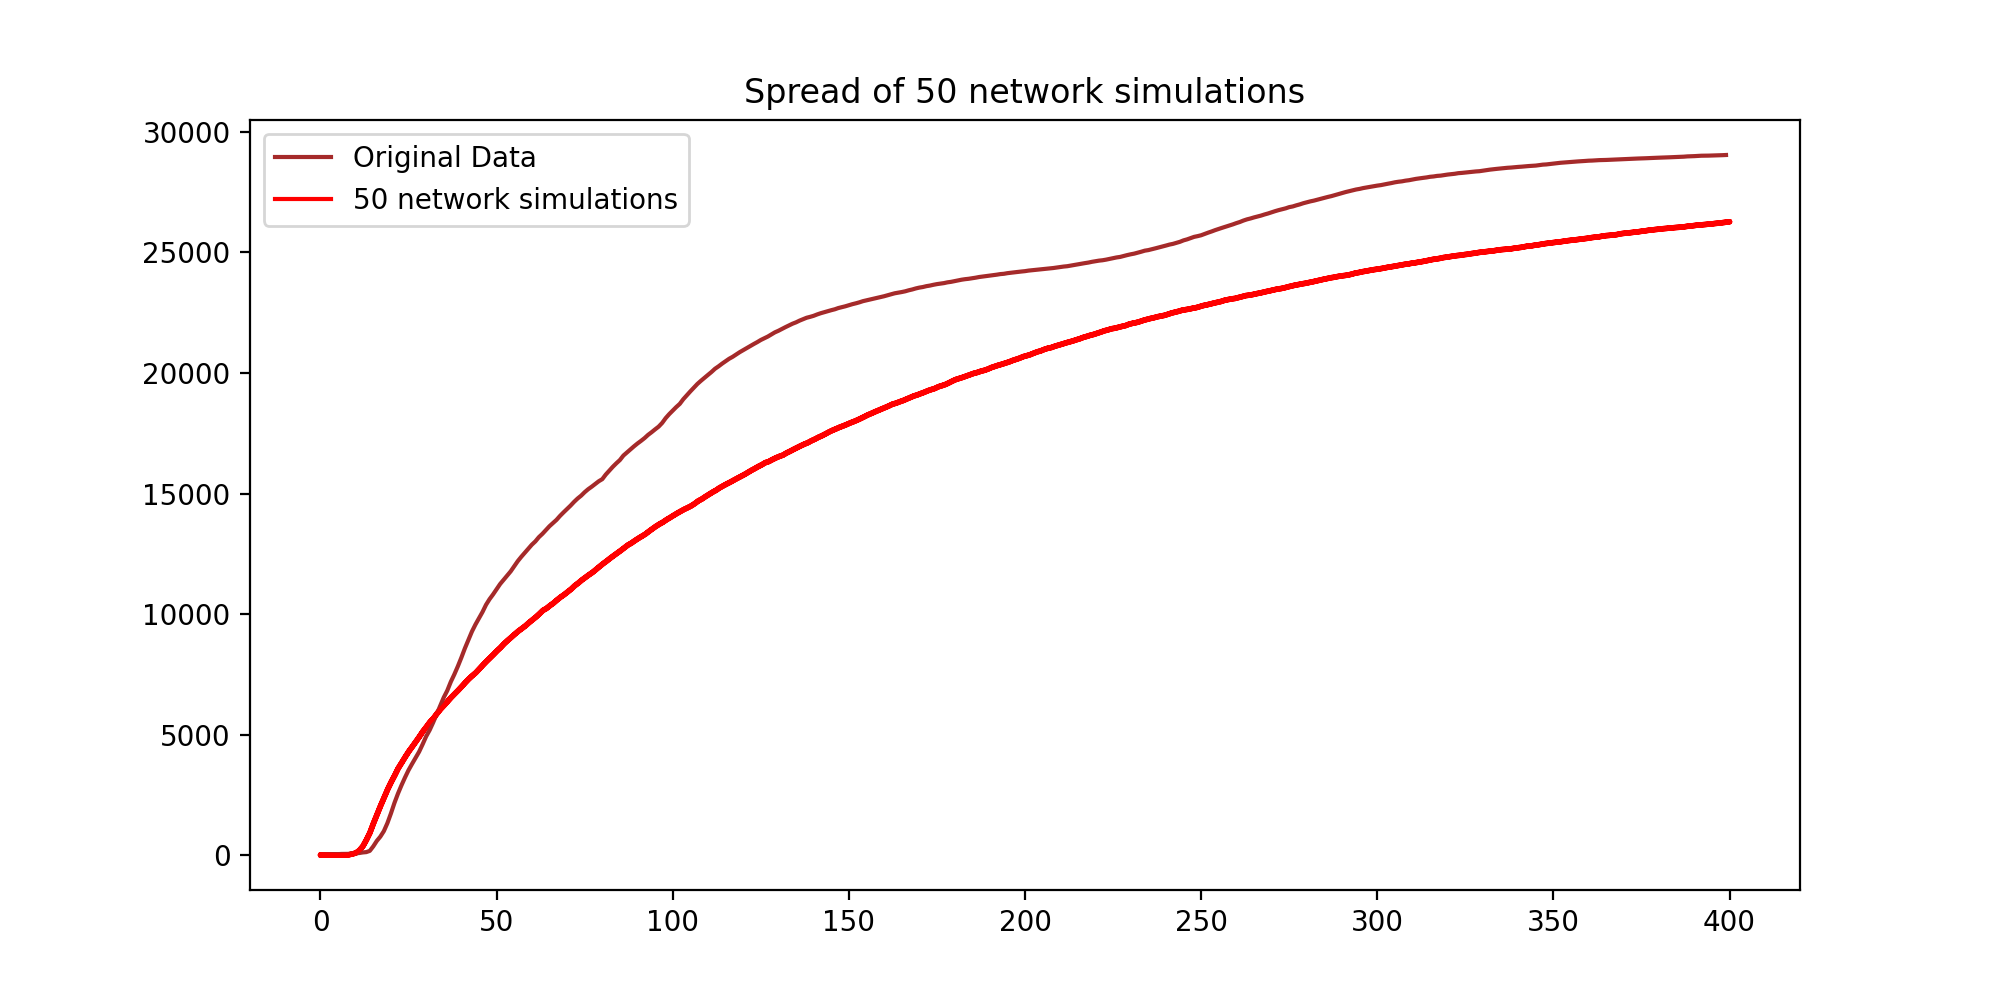

In [21]:
x_common = np.linspace(0,400,400)

plt.figure(figsize=(10, 5))

plt.title('Spread of 50 network simulations')

# y = np.stack(I_simulations)

ymax = np.max(df, axis=0)
ymin = np.min(df, axis=0)

plt.plot(yData, 'brown', label='Original Data')

plt.plot(x_common, ymax, 'red', label='50 network simulations')
plt.plot(x_common, ymin, 'red')

plt.fill_between(x_common, ymax, ymin, facecolor=(1, 0, 0, 0.2), hatch ='/', edgecolor='red', linewidth=2)

plt.legend()

plt.savefig('../images/50_network_spread.png')

plt.show()

In [84]:
y

array([[2.00000000e+00, 1.50000000e+01, 3.30000000e+01, ...,
        2.64590000e+04, 2.64770000e+04, 2.64860000e+04],
       [2.00000000e+00, 1.20000000e+01, 2.50000000e+01, ...,
        2.62071971e+04, 2.62190000e+04, 2.62290000e+04],
       [2.00000000e+00, 8.00000000e+00, 1.20000000e+01, ...,
        2.59360000e+04, 2.59451967e+04, 2.59600000e+04],
       ...,
       [2.00000000e+00, 8.00000000e+00, 1.30000000e+01, ...,
        2.63952391e+04, 2.64045838e+04, 2.64120000e+04],
       [2.00000000e+00, 1.50000000e+01, 2.60000000e+01, ...,
        2.62541804e+04, 2.62700000e+04, 2.62800000e+04],
       [2.00000000e+00, 7.00000000e+00, 1.60000000e+01, ...,
        2.66080000e+04, 2.66270000e+04, 2.66360000e+04]])

In [33]:
import csv
with open('../eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)

    for row in I_simulations:
        spamwriter.writerow(row)

In [7]:
df = pd.read_csv('../eggs.csv', header=None)

In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,2.0,8.0,14.950151,23.95812,30.278983,36.023252,38.452089,44.595434,52.281246,56.385438,...,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0
1,2.0,8.0,14.000000,17.00000,23.123931,31.159154,38.463772,43.310577,49.856043,57.358526,...,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0


In [26]:
df.rows

AttributeError: 'DataFrame' object has no attribute 'rows'

In [14]:
I_simulations = []

for index, row in df.iterrows():
    I_simulations.append(row)

In [19]:
df = pd.read_csv('../simulations.csv', header=None)

In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,2.0,2.0,2.0,2.0,3.0,4.0,5.0,7.0,11.0,43.0,...,26138.553372,26147.0,26160.102438,26175.0,26187.0,26205.615337,26219.0,26237.34206,26257.0,26274.0


In [12]:
ymin

0

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,2.0,8.0,14.950151,23.95812,30.278983,36.023252,38.452089,44.595434,52.281246,56.385438,...,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0
1,2.0,8.0,14.000000,17.00000,23.123931,31.159154,38.463772,43.310577,49.856043,57.358526,...,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0


In [17]:
I_simulations[1]


0        2.000000
1        8.000000
2       14.000000
3       17.000000
4       23.123931
          ...    
395    452.000000
396    452.000000
397    452.000000
398    452.000000
399    452.000000
Name: 1, Length: 400, dtype: float64

In [22]:
ymax

0          2.000000
1          2.000000
2          2.000000
3          2.000000
4          3.000000
           ...     
395    26205.615337
396    26219.000000
397    26237.342060
398    26257.000000
399    26274.000000
Length: 400, dtype: float64

In [23]:
ymin

0          2.000000
1          2.000000
2          2.000000
3          2.000000
4          3.000000
           ...     
395    26205.615337
396    26219.000000
397    26237.342060
398    26257.000000
399    26274.000000
Length: 400, dtype: float64

In [25]:
np.interp(x_common, t, I)

NameError: name 't' is not defined

In [26]:
np.linspace(0, 400, 400)

array([  0.        ,   1.00250627,   2.00501253,   3.0075188 ,
         4.01002506,   5.01253133,   6.01503759,   7.01754386,
         8.02005013,   9.02255639,  10.02506266,  11.02756892,
        12.03007519,  13.03258145,  14.03508772,  15.03759398,
        16.04010025,  17.04260652,  18.04511278,  19.04761905,
        20.05012531,  21.05263158,  22.05513784,  23.05764411,
        24.06015038,  25.06265664,  26.06516291,  27.06766917,
        28.07017544,  29.0726817 ,  30.07518797,  31.07769424,
        32.0802005 ,  33.08270677,  34.08521303,  35.0877193 ,
        36.09022556,  37.09273183,  38.0952381 ,  39.09774436,
        40.10025063,  41.10275689,  42.10526316,  43.10776942,
        44.11027569,  45.11278195,  46.11528822,  47.11779449,
        48.12030075,  49.12280702,  50.12531328,  51.12781955,
        52.13032581,  53.13283208,  54.13533835,  55.13784461,
        56.14035088,  57.14285714,  58.14536341,  59.14786967,
        60.15037594,  61.15288221,  62.15538847,  63.15

In [ ]:
TRUMP_CHANTING_VERIFIED
trump_chanting_verified

Judicial_Watch_alleges_stolen_election_raw

judicial_watch_alleges_stolen_election_raw

ballot_harvesting_ilhan_omar_project_veritas_video_raw

machines_westmoreland_machines_down_raw